# Lendingkart

In [1]:
# Load necessary libraries
import sys
import glob
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import gensim
import spacy
import numpy as np
import tqdm.notebook as tqdm
from pprint import pprint
import pickle 
import pyLDAvis

sys.path.append('/Users/pushkar/Documents/projects/fin_comp/comp/docs')

from utils.helper import Processor

In [2]:
# Load data
df = pd.read_csv('./../../data/fintech/lendingkart/lendingkart.csv')

In [3]:
# Know the shape of the loaded data
df.shape

(5490, 27)

## Preprocessing

In [4]:
# Preprocess the data
processor = Processor('./../../data/config.json')
pre_df, post_df = processor.preprocess(df)

In [5]:
# Create dictionaries
pre_id2word = gensim.corpora.Dictionary(pre_df['bigram'].values.tolist())
post_id2word = gensim.corpora.Dictionary(post_df['bigram'].values.tolist())

In [6]:
# Create corpus
pre_corpus = [pre_id2word.doc2bow(text) for text in pre_df['bigram'].values.tolist()]
post_corpus = [post_id2word.doc2bow(text) for text in post_df['bigram'].values.tolist()]

## Base Model

### Training

In [7]:
pre_lda_model = gensim.models.LdaMulticore(corpus=pre_corpus,
                                        id2word=pre_id2word,
                                        num_topics=10,
                                        random_state=42,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True)

In [8]:
pprint(pre_lda_model.print_topics())
pre_doc_lda = pre_lda_model[pre_corpus]

[(0,
  '0.020*"lendingkart" + 0.011*"india" + 0.009*"smooth_finance" + '
  '0.008*"documents" + 0.008*"heres" + 0.007*"help" + 0.007*"check" + '
  '0.006*"resource_msme" + 0.006*"platforms_provides" + '
  '0.006*"capital_techcrunch"'),
 (1,
  '0.063*"indias_lendingkart" + 0.063*"access_working" + '
  '0.060*"small_businesses" + 0.059*"raises_help" + 0.059*"capital" + '
  '0.011*"lendingkart" + 0.007*"helping" + 0.007*"loan" + 0.005*"team" + '
  '0.005*"thank"'),
 (2,
  '0.038*"thank" + 0.022*"hello" + 0.018*"business" + 0.017*"contact_details" '
  '+ 0.016*"loan" + 0.014*"dear_customer" + 0.010*"carecom" + '
  '0.009*"regret_inconvenience" + 0.009*"representatives_contact" + '
  '0.009*"share_registered"'),
 (3,
  '0.043*"lendingkart" + 0.011*"business" + 0.009*"hackathon" + '
  '0.009*"register" + 0.008*"team" + 0.008*"know" + 0.007*"number" + '
  '0.007*"days" + 0.007*"event" + 0.006*"dont"'),
 (4,
  '0.018*"loan" + 0.010*"lendingkart" + 0.009*"lendingkart_raises" + '
  '0.008*"busin

In [9]:
post_lda_model = gensim.models.LdaMulticore(corpus=post_corpus,
                                        id2word=post_id2word,
                                        num_topics=10,
                                        random_state=42,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True)

In [10]:
pprint(post_lda_model.print_topics())
post_doc_lda = post_lda_model[post_corpus]

[(0,
  '0.057*"details" + 0.037*"contact" + 0.030*"hello" + 0.028*"concern" + '
  '0.027*"kindly_dm" + 0.027*"contact_solve" + 0.027*"concern_looking" + '
  '0.026*"forward_serve" + 0.025*"shall_happy" + 0.025*"experience_officer"'),
 (1,
  '0.025*"lendingkart" + 0.012*"rs_crore" + 0.010*"thanks_kind" + '
  '0.010*"patience_cooperation" + 0.010*"business" + 0.009*"financial" + '
  '0.009*"sir" + 0.009*"loan" + 0.008*"approved" + 0.008*"order"'),
 (2,
  '0.045*"deeply_value" + 0.044*"association_reassure" + '
  '0.043*"committed_serving" + 0.043*"team_fully" + 0.026*"dear_sir" + '
  '0.024*"better" + 0.020*"better_thank" + 0.017*"conversation_representative" '
  '+ 0.017*"hope_satisfied" + 0.017*"connect_soon"'),
 (3,
  '0.022*"lendingkart" + 0.012*"company" + 0.011*"deducted" + 0.011*"help" + '
  '0.010*"emi" + 0.008*"time" + 0.008*"mail" + 0.007*"like" + 0.007*"raised" + '
  '0.007*"sir"'),
 (4,
  '0.018*"loan" + 0.010*"customer_care" + 0.008*"company" + 0.008*"bank" + '
  '0.007*"ur"

### Evaluation

In [11]:
pre_coherence_model_lda = gensim.models.CoherenceModel(model=pre_lda_model, 
                                                    texts=pre_df['bigram'].values.tolist(), 
                                                    dictionary=pre_id2word, 
                                                    coherence='u_mass')
pre_coherence_lda = pre_coherence_model_lda.get_coherence()
print('Pre-COVID Coherence Score: ', pre_coherence_lda)

Pre-COVID Coherence Score:  -12.041326886953787


In [12]:
post_coherence_model_lda = gensim.models.CoherenceModel(model=post_lda_model, 
                                                    texts=post_df['bigram'].values.tolist(), 
                                                    dictionary=post_id2word, 
                                                    coherence='u_mass')
post_coherence_lda = post_coherence_model_lda.get_coherence()
print('Post-COVID Coherence Score: ', post_coherence_lda)

Post-COVID Coherence Score:  -8.807710960349542


## Hyper-parameter tuning

### Pre-COVID

In [13]:
pre_df_result = processor.perform_hyperparameter_tuning(pre_corpus, 
                                                        pre_id2word, 
                                                        pre_df['bigram'].values.tolist(), 
                                                        "./../../data/fintech/lendingkart/pre.csv")

100%|██████████| 780/780 [3:45:28<00:00, 17.34s/it]    


In [15]:
pre_df_result

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75.0% Corpus,2,0.01,0.01,-11.630625
1,75.0% Corpus,2,0.01,0.31,-10.852349
2,75.0% Corpus,2,0.01,0.61,-9.803300
3,75.0% Corpus,2,0.01,0.9099999999999999,-10.415090
4,75.0% Corpus,2,0.01,symmetric,-10.713609
...,...,...,...,...,...
775,100% Corpus,14,asymmetric,0.01,-11.742100
776,100% Corpus,14,asymmetric,0.31,-11.115104
777,100% Corpus,14,asymmetric,0.61,-11.643153
778,100% Corpus,14,asymmetric,0.9099999999999999,-11.507668


In [16]:
# pre_df_result = pd.read_csv("./../../data/fintech/lendingkart/pre.csv")

In [17]:
# Maximum coherence
pre_df_result.sort_values('Coherence', ascending=False, inplace=True)
pre_df_result.head(10)

,Validation_Set,Topics,Alpha,Beta,Coherence
648,100% Corpus,10,0.9099999999999999,0.9099999999999999,-8.503835
438,100% Corpus,3,0.9099999999999999,0.9099999999999999,-8.570930
428,100% Corpus,3,0.31,0.9099999999999999,-8.860387
437,100% Corpus,3,0.9099999999999999,0.61,-8.903289
443,100% Corpus,3,symmetric,0.9099999999999999,-8.948995
432,100% Corpus,3,0.61,0.61,-8.987103
435,100% Corpus,3,0.9099999999999999,0.01,-9.103997
442,100% Corpus,3,symmetric,0.61,-9.117170
58,75.0% Corpus,3,asymmetric,0.9099999999999999,-9.132598
469,100% Corpus,4,0.9099999999999999,symmetric,-9.161936


In [18]:
pre_topics_score = []
for i in pre_df_result['Topics'].value_counts().index:
    data = []
    data.append(i)
    temp = pre_df_result[(pre_df_result['Topics'] == i) & (pre_df_result['Alpha'] == pre_df_result['Alpha'].unique()[0]) & (pre_df_result['Beta'] == pre_df_result['Beta'].unique()[0])]
    max_value = temp['Coherence'].max()
    data.append(max_value)
    pre_topics_score.append(data)

In [19]:
pre_ts_df = pd.DataFrame(pre_topics_score)
pre_ts_df.columns = ['topics', 'coherence']

In [20]:
pre_ts_df.sort_values('topics', inplace=True)
pre_ts_df.head()

,topics,coherence
4,2,-10.148427
1,3,-8.570930
2,4,-9.724897
5,5,-10.975091
8,6,-11.300579


<AxesSubplot: xlabel='topics'>

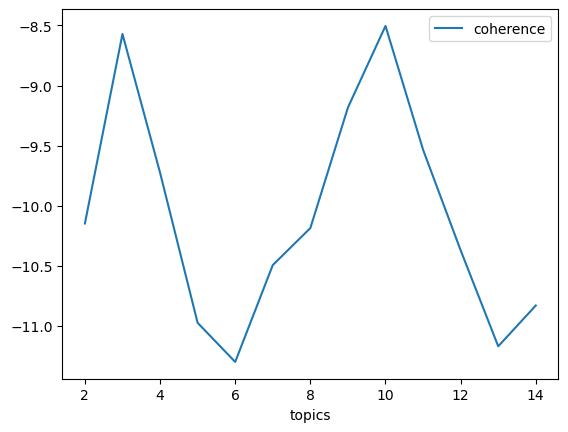

In [21]:
pre_ts_df.plot.line(x='topics', y='coherence')

In [23]:
pre_df_result[pre_df_result['Topics'] == 3].head(5)

,Validation_Set,Topics,Alpha,Beta,Coherence
438,100% Corpus,3,0.9099999999999999,0.9099999999999999,-8.570930
428,100% Corpus,3,0.31,0.9099999999999999,-8.860387
437,100% Corpus,3,0.9099999999999999,0.61,-8.903289
443,100% Corpus,3,symmetric,0.9099999999999999,-8.948995
432,100% Corpus,3,0.61,0.61,-8.987103


### Post-COVID

In [24]:
post_df_result = processor.perform_hyperparameter_tuning(post_corpus, 
                                                        post_id2word, 
                                                        post_df['bigram'].values.tolist(), 
                                                        "./../../data/fintech/lendingkart/post.csv")

  2%|▏         | 16/780 [00:48<38:27,  3.02s/it]

In [ ]:
post_df_result.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,-4.654281
1,75% Corpus,2,0.01,0.31,-4.997103
2,75% Corpus,2,0.01,0.61,-5.439204
3,75% Corpus,2,0.01,0.91,-6.112097
4,75% Corpus,2,0.01,symmetric,-5.273664


In [ ]:
# post_df_result = pd.read_csv("./../../data/fintech/lendingkart/post.csv")

In [ ]:
# Maximum coherence
post_df_result.sort_values('Coherence', ascending=False, inplace=True)
post_df_result.head(10)

,Validation_Set,Topics,Alpha,Beta,Coherence
906,100% Corpus,3,0.31,0.31,-2.600956
904,100% Corpus,3,0.01,symmetric,-2.808227
923,100% Corpus,3,symmetric,0.9099999999999999,-2.882595
53,75% Corpus,3,symmetric,0.9099999999999999,-2.890555
31,75% Corpus,3,0.01,0.31,-2.930297
52,75% Corpus,3,symmetric,0.61,-2.940758
40,75% Corpus,3,0.61,0.01,-2.974750
974,100% Corpus,5,0.61,symmetric,-3.012792
920,100% Corpus,3,symmetric,0.01,-3.019088
33,75% Corpus,3,0.01,0.9099999999999999,-3.024148


In [ ]:
post_topics_score = []
for i in post_df_result['Topics'].value_counts().index:
    data = []
    data.append(i)
    temp = post_df_result[(post_df_result['Topics'] == i) & (post_df_result['Alpha'] == '0.31') & (post_df_result['Beta'] == '0.31')]
    max_value = temp['Coherence'].max()
    data.append(max_value)
    post_topics_score.append(data)

In [ ]:
post_ts_df = pd.DataFrame(post_topics_score)
post_ts_df.columns = ['topics', 'coherence']

In [ ]:
post_ts_df.sort_values('topics', inplace=True)
post_ts_df.head()

,topics,coherence
22,2,-5.266902
0,3,-2.600956
27,4,-4.121743
15,5,-5.475176
26,6,-3.341852


<AxesSubplot: xlabel='topics'>

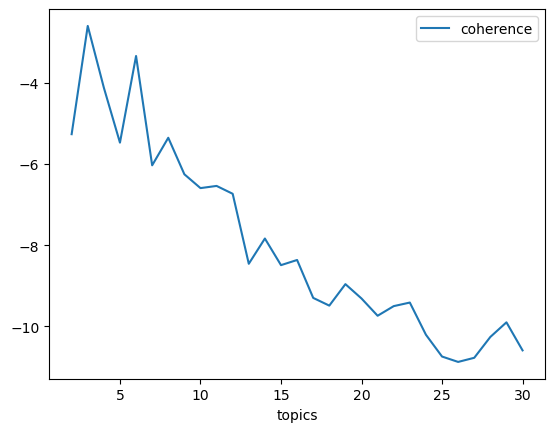

In [ ]:
post_ts_df.plot.line(x='topics', y='coherence')

In [ ]:
post_df_result[(post_df_result['Topics'] == 3)].head()

,Validation_Set,Topics,Alpha,Beta,Coherence
30,75% Corpus,3,0.01,0.01,-3.261263
31,75% Corpus,3,0.01,0.31,-2.930297
32,75% Corpus,3,0.01,0.61,-3.353968
33,75% Corpus,3,0.01,0.91,-3.024148
34,75% Corpus,3,0.01,symmetric,-3.368206
35,75% Corpus,3,0.31,0.01,-3.336116
36,75% Corpus,3,0.31,0.31,-3.148272
37,75% Corpus,3,0.31,0.61,-3.593593
38,75% Corpus,3,0.31,0.91,-3.047007
39,75% Corpus,3,0.31,symmetric,-3.199338


## Final Models

### Pre-COVID

In [72]:
pre_final_lda_model = gensim.models.LdaMulticore(corpus=pre_corpus,
                                        id2word=pre_id2word,
                                        num_topics=4,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha=pre_df_result['Alpha'].unique()[3],
                                        eta=pre_df_result['Alpha'].unique()[3])

In [73]:
pre_final_coherence_model_lda = gensim.models.CoherenceModel(model=pre_final_lda_model, 
                                                    texts=pre_df['bigram'].values.tolist(), 
                                                    dictionary=pre_id2word, 
                                                    coherence='u_mass')
pre_final_coherence_lda = pre_final_coherence_model_lda.get_coherence()
print('Pre-COVID Coherence Score: ', pre_final_coherence_lda)

Pre-COVID Coherence Score:  -7.097591841005574


### Post-COVID

In [76]:
post_final_lda_model = gensim.models.LdaMulticore(corpus=post_corpus,
                                        id2word=post_id2word,
                                        num_topics=3,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha=0.31,
                                        eta=0.31)

In [77]:
post_final_coherence_model_lda = gensim.models.CoherenceModel(model=post_final_lda_model, 
                                                    texts=post_df['bigram'].values.tolist(), 
                                                    dictionary=post_id2word, 
                                                    coherence='u_mass')
post_final_coherence_lda = post_final_coherence_model_lda.get_coherence()
print('Pre-COVID Coherence Score: ', post_final_coherence_lda)

Pre-COVID Coherence Score:  -3.2576656642336856


## Inferencing

In [100]:
def dominant_topics(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True
                )
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.rename(columns={0: "Text"}, inplace=True)
    return sent_topics_df

In [106]:
pre_df_topic_sents_keywords = dominant_topics(
   ldamodel=pre_final_lda_model, corpus=pre_corpus, texts=pre_df['bigram'].values.tolist()
)

/var/folders/zl/bqtzmz3s0xl5_ddgbjsqxsww0000gn/T/ipykernel_2708/2297222571.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(


In [107]:
pre_df_topic_sents_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,2,0.7898,"thank, hello, carecom, loan, assist, details, ...","[hello, seemant, regret, inconvenience_caused,..."
1,1,0.6428,"lendingkart, heres, business, loan, know, help...","[sir, got, message, request, consider, issuing..."
2,2,0.3873,"thank, hello, carecom, loan, assist, details, ...","[banknbfc, carecom]"
3,1,0.6512,"lendingkart, heres, business, loan, know, help...","[profitable, indian, sme, cr, turnover, good, ..."
4,2,0.7924,"thank, hello, carecom, loan, assist, details, ...","[mobile_number, mail, jawedqamar, com, jj, ent..."
...,...,...,...,...
1430,2,0.8189,"thank, hello, carecom, loan, assist, details, ...","[hi, avinash, regret, inconvenience_caused, sh..."
1431,2,0.8427,"thank, hello, carecom, loan, assist, details, ...","[wish, let, guys, know, running, scam, horribl..."
1432,0,0.3552,"lendingkart, india, alteria_capital, team, cap...",[lendingkart]
1433,1,0.3130,"lendingkart, heres, business, loan, know, help...","[yup, thats]"


In [113]:
pre_df_topic_sents_keywords['Topic_Keywords'].unique()

array(['thank, hello, carecom, loan, assist, details, share, business, days, company',
       'lendingkart, heres, business, loan, know, help, growth, business_loan, need, work',
       'lendingkart, india, alteria_capital, team, capital, raised, lendingkart_raises, existing_investors, million, led',
       'raises, working_capital, indias_lendingkart, help_small, businesses_access, techcrunch, sector, industry, lendingkart, msmes'],
      dtype=object)

In [109]:
post_df_topic_sents_keywords = dominant_topics(
   ldamodel=post_final_lda_model, corpus=post_corpus, texts=post_df['bigram'].values.tolist()
)

/var/folders/zl/bqtzmz3s0xl5_ddgbjsqxsww0000gn/T/ipykernel_2708/2297222571.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(


In [112]:
post_df_topic_sents_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,1,0.9751,"lendingkart, emi, loan, moratorium, number, co...","[loan_id, lai, reverse, covid, releaf, govt, e..."
1,1,0.9751,"lendingkart, emi, loan, moratorium, number, co...","[loan_id, lai, reverse, covid, releaf, govt, e..."
2,1,0.9427,"lendingkart, emi, loan, moratorium, number, co...","[recvd, thing, end, kindly, let, know, getting..."
3,1,0.9002,"lendingkart, emi, loan, moratorium, number, co...","[dear, asking, restructuring, forcing, settle,..."
4,2,0.9581,"serve, share, registered_contact, details, cus...","[hello, kindly_dm, share, registered_contact, ..."
...,...,...,...,...
4050,1,0.6735,"lendingkart, emi, loan, moratorium, number, co...","[speaker, alert, join, mithun_sundar, ceo, mit..."
4051,1,0.9668,"lendingkart, emi, loan, moratorium, number, co...","[union, earmarked, rs_crore, ministry, announc..."
4052,1,0.9400,"lendingkart, emi, loan, moratorium, number, co...","[satisfied, hona, hai, aur, mera, documents, a..."
4053,1,0.9822,"lendingkart, emi, loan, moratorium, number, co...","[help, mai, se, loan, apply, kiya, approval, h..."


In [114]:
post_df_topic_sents_keywords['Topic_Keywords'].unique()

array(['lendingkart, emi, loan, moratorium, number, company, reach, mail, able, trying',
       'serve, share, registered_contact, details, customer_experience, kindly_dm, officer_shall, happy, contact_solve, forward',
       'team, association, deeply_value, reassure, details, fully_committed, soon, serving, giving, chance'],
      dtype=object)

In [110]:
pre_df_topic_sents_keywords['Dominant_Topic'].value_counts()

0    479
1    333
2    329
3    294
Name: Dominant_Topic, dtype: int64

In [111]:
post_df_topic_sents_keywords['Dominant_Topic'].value_counts()

1    2191
0    1094
2     770
Name: Dominant_Topic, dtype: int64